#mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/assignment

[Errno 2] No such file or directory: 'drive/MyDrive/assignment'
/content


In [ ]:
!pip install scikeras
!pip install umap-learn

# import libraries

In [ ]:

import os
import math
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pickle

import pandas as pd
import numpy as np

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score


import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy

# Helper Functions

In [ ]:

def read_df(path, show_details):
  df = pd.read_csv(path, encoding='utf8')
  if show_details:
    file_name = path.split("/")[-1]
    print(f"shape of {file_name}: {df.shape}")
  return df

def count_total_nan(df):
  return df.isnull().sum().sum()

def get_df_after_deduct_columns(df, columns):
  return df.loc[:, ~df.columns.isin(columns)]

def concate_df(dfs):
    return pd.concat(dfs, ignore_index=True, sort=False)

def Union_(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list

def createDirectory(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

def plot_graph(history):
  plt.figure(figsize=(16, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training and Validation Loss')
  plt.show()


def plot_confusion_matrix(y_actu,
                          y_pred,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          classes=["real", "fake"],
                          FOLD=None,
                          save_path=False):

    cf_matrix = tf.math.confusion_matrix(labels=y_actu,predictions=y_pred).numpy()

    f1 = f1_score(y_actu, y_pred)
    pr = precision_score(y_actu, y_pred)
    rec = recall_score(y_actu, y_pred)

    # calculate accuracy , precision, recall and f1 score for each class
    accuracy = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    TP = np.diag(cf_matrix)
    FP = np.sum(cf_matrix, axis=0) - TP
    FN = np.sum(cf_matrix, axis=1) - TP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    i = 0
    text = '\n'
    F1 =[]
    for class_name in classes:
        f1 = (2 * precision[i] * recall[i]) / (precision[i] + recall[i])
        F1.append(f1)
        text = text + class_name + '==> Precision:{0: .2}'.format(
            precision[i]) + ', Recall:{0: .2}'.format(
            recall[i]) + ', F1:{0: .2}'.format(f1) + '\n'
        i += 1

    # stats_text = "\nAccuracy={:0.2%},Precision={:0.2%},Recall={:0.2%},F1={:0.2%},".format(accuracy,np.mean(precision),np.mean(recall),np.mean(F1)) + text
    stats_text = "\nAccuracy={:0.2%},Precision={:0.2%},Recall={:0.2%},F1={:0.2%},".format(accuracy,pr,rec,f1) + text

    # add info into confusion matrix
    group_counts = ["{0: 0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0: .2%}".format(value)
        for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    labels = [
        f"{v1}\n {v2}" for v1, v2 in zip(group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(len(classes), len(classes))

    figure = plt.figure(figsize=(8, 7))
    plt.subplots_adjust(top=0.95,
                        bottom=0.22,
                        left=0.1,
                        right=0.95,
                        hspace=0.2,
                        wspace=0.2)

    sns.heatmap(cf_matrix,
                annot=labels,
                cbar=False,
                xticklabels=classes,
                yticklabels=classes,
                fmt='',
                cmap=cmap)
    plt.ylabel('True Label')
    plt.xlabel("Predicted Label\n" + stats_text)
    if FOLD is None:
        plt.title(title)
    else:
        plt.title(title + "(FOLD: " + str(FOLD) + ")")

    if save_path:
        plt.savefig(save_path)


def show_values_on_bars(axs, total, h_v="v", space=0.9, percentige=False):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                if percentige:
                    value = str(int(p.get_height()))
                    percentage = str('{:.1f}%'.format(100 * p.get_height()/total))
                    text = "\n"+value+"\n"+percentage
                else:
                    text = str(int(p.get_height()))
                ax.text(_x, _y, text, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()-(p.get_height()/2-.1)
                if percentige:
                    value = str(int(p.get_width()))
                    percentage = str('{:.1f}%'.format(100 * p.get_width()/total))
                    text = "\n"+value+"\n"+percentage
                else:
                    text = str(int(p.get_width()))
                ax.text(_x, _y, text, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


def _bargram(x,y, fig_size=[15, 6], alpha=0.7,x_label_rotation=0,h_v='v',percentige=False, text='',
               xlabel="Annotators combinations", ylabel="similar annotation percentage",
               title="",save_path='output/x.png'):

    sns.set(style='whitegrid', palette='muted', font_scale=1.2)
    sns.set(font="/usr/share/fonts/truetype/kalpurush.ttf")
    HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
    sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))


    plt.figure(figsize=(fig_size))

    ax = sns.barplot(x=x, y=y,errwidth='0.7', alpha=alpha)
    if x_label_rotation !=0:
        for item in ax.get_xticklabels():
            item.set_rotation(x_label_rotation)

    if text != '':
        props = dict(boxstyle='round', facecolor='b', alpha=0.3)
        ax.text(0.85, 0.89, text, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
    if h_v != '':
        if(h_v=='h'):
            total=sum(x)
        else:
            total=sum(y)

        show_values_on_bars(ax,total, h_v= h_v, space=.9, percentige=percentige)


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if save_path != False:
        plt.savefig(save_path)
    plt.subplots_adjust(left=0, right=1.4, top=1.4, bottom=0.3)


In [ ]:
createDirectory("output")

'output'

# Reading data

In [ ]:
df_train1 = read_df("drive/MyDrive/training1.csv", show_details=True)
df_train2 = read_df("drive/MyDrive/training2.csv", show_details=True)

#merge 2 train dataset
df_train = concate_df([df_train1,df_train2])
print("shape after marge:", df_train.shape)

df_train_X = get_df_after_deduct_columns(df_train,['label','confidence'])
df_train_Y = df_train[['label','confidence']]

total_nan = count_total_nan(df_train)
print("total_nan: ",total_nan)

shape of training1.csv: (600, 4610)
shape of training2.csv: (2800, 4610)
shape after marge: (3400, 4610)
total_nan:  2578317


In [ ]:
df_test_X = read_df("drive/MyDrive/test.csv", show_details=True)
df_test_Y = read_df("drive/MyDrive/sample_valid_predictions.csv", show_details=True)

total_nan = count_total_nan(df_test_X)
print("total_nan: ",total_nan)

shape of test.csv: (2000, 4608)
shape of sample_valid_predictions.csv: (2000, 1)
total_nan:  1844371


# handling NaN data

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer

'''
Parameter
df -> pd.DataFrame
strategy -> Depends on the list but it has 3 types of strategy, constant, mean, median
mean took to long to use so just kept it to constant and mean
returns an np.arrary of constant values or a mean value for the NaN values.
'''

def simple_imputer(df, strategy='mean'):
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp.fit(df)
  x= imp.transform(df)
  total_nan = np.count_nonzero(np.isnan(x))
  print(f"Total NaN after apply {strategy}: ", total_nan, ", shape: ",x.shape)
  return x

#takes 3 hours to run then crashes on there own
def iterative_imputer(df):
  impute_it = IterativeImputer(verbose=1, n_nearest_features=100)
  x =impute_it.fit_transform(df)
  total_nan = np.count_nonzero(np.isnan(x))
  print(f"Total NaN after apply iterative_imputer: ", total_nan, ", shape: ",x.shape)
  return x

def knn_imputer(df, k=5):
  impute_knn = KNNImputer(n_neighbors=k)
  x =impute_knn.fit_transform(df)
  total_nan = np.count_nonzero(np.isnan(x))
  print(f"Total NaN after apply knn_imputer: ", total_nan, ", shape: ",x.shape)
  return x


In [ ]:
'''
Parameters
df -> pd.DataFrame
method -> list of str
returns an np.array after the NaN hanlders were used, i tried to use other NaN handlers but it kept on crashing so i kept the code here to show that i tried to use different handlers
'''
def handling_missing_value(df:pd.DataFrame, method:str) -> np.array:
  df = df.copy(deep=True)
  #Replace the missing value with '0' using 'fiilna' method
  print("Total NaN before: ", count_total_nan(df), ", shape: ",df.shape)
  if method in ["constant","mean", "median"]:
    return simple_imputer(df, strategy=method)
  elif method == 'iterative_imputer':
    return iterative_imputer(df)
  elif method == 'knn_imputer':
    return knn_imputer(df, k=10)

In [ ]:
#apply differnt methods for missing data recovery
# not in use -> ["median", "iterative_imputer", "knn_imputer"]
methods = ["constant","mean"]

In [ ]:
datasets = []
for method in tqdm(methods):
  train_X = handling_missing_value(df_train_X, method)
  test_X = handling_missing_value(df_test_X, method)

  #scaling the features
  scaler = preprocessing.StandardScaler().fit(train_X)
  train_X = scaler.transform(train_X)
  test_X = scaler.transform(test_X)

  datasets.append([train_X, test_X])


  0%|          | 0/2 [00:00<?, ?it/s]

Total NaN before:  2578317 , shape:  (3400, 4608)
Total NaN after apply constant:  0 , shape:  (3400, 4608)
Total NaN before:  1844371 , shape:  (2000, 4608)
Total NaN after apply constant:  0 , shape:  (2000, 4608)
Total NaN before:  2578317 , shape:  (3400, 4608)
Total NaN after apply mean:  0 , shape:  (3400, 4608)
Total NaN before:  1844371 , shape:  (2000, 4608)
Total NaN after apply mean:  0 , shape:  (2000, 4608)


In [ ]:
with open('nan.pkl', 'wb') as f:
  pickle.dump(datasets, f)

In [ ]:
with open('nan.pkl', 'rb') as f:
  datasets = pickle.load(f)

# Label processing

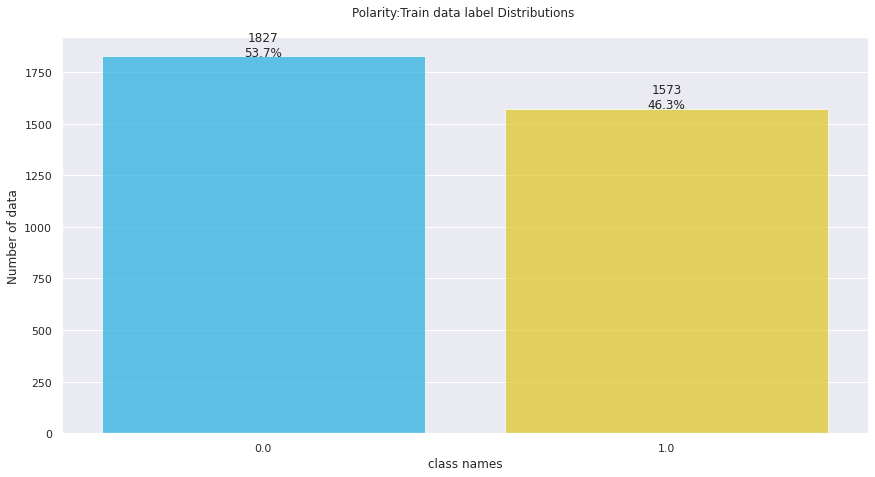

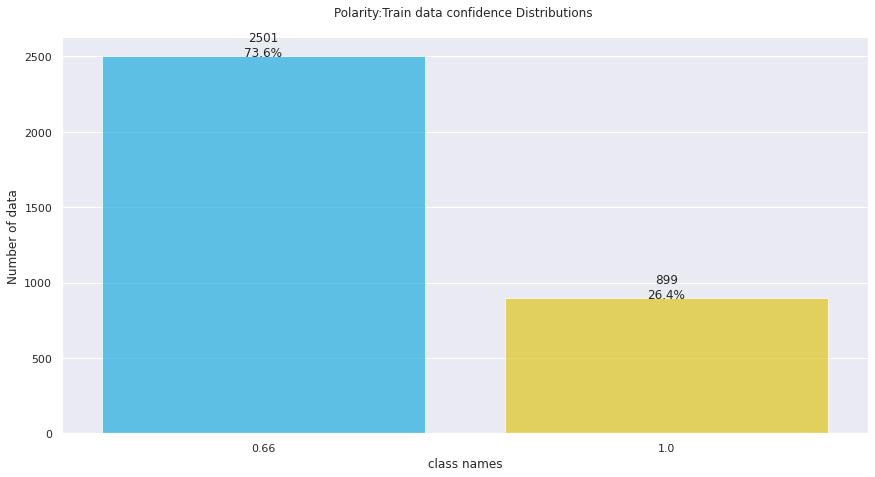

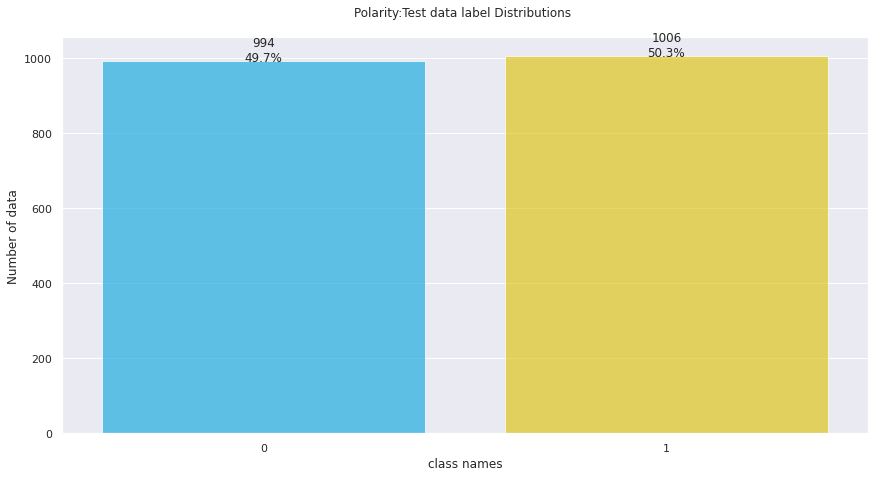

In [ ]:
#show class distribution
x= df_train_Y['label'].value_counts().index
y = df_train_Y['label'].value_counts().values

_bargram(x=x, y=y, fig_size=[8, 5], alpha=0.7,x_label_rotation=0,h_v='v',percentige=True, text='', xlabel="class names", ylabel="Number of data",
               title="Polarity:Train data label Distributions \n", save_path='output/train_label_distribution')

#show confidence distribution
x= df_train_Y['confidence'].value_counts().index
y = df_train_Y['confidence'].value_counts().values

_bargram(x=x, y=y, fig_size=[8, 5], alpha=0.7,x_label_rotation=0,h_v='v',percentige=True, text='', xlabel="class names", ylabel="Number of data",
               title="Polarity:Train data confidence Distributions \n",  save_path='output/train_confidence_distribution')

#show class distribution of test data
x= df_test_Y['prediction'].value_counts().index
y = df_test_Y['prediction'].value_counts().values

_bargram(x=x, y=y, fig_size=[8, 5], alpha=0.7,x_label_rotation=0,h_v='v',percentige=True, text='', xlabel="class names", ylabel="Number of data",
               title="Polarity:Test data label Distributions \n", save_path='output/test_label_distribution')

In [ ]:
# encode label
train_Y = df_train_Y['label'].values
test_Y = df_test_Y['prediction'].values

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_Y)
train_Y = encoder.transform(train_Y)
test_Y = encoder.transform(test_Y)

# Dimention Reduction

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import umap


'''
Parameter
train_data -> np.ndarrary
test_data -> np.ndarray
returns the cnn features only as x train and x test
'''
def take_only_cnn_feature(train_data, test_data):
  X_train_cnn = train_data[:,:4095]
  X_test_cnn = test_data[:,:4095]
  return X_train_cnn,X_test_cnn

'''
Parameter
train_data -> np.ndarrary
test_data -> np.ndarray
returns the gist features only as x train and x test
'''
def take_only_gist_feature(train_data, test_data):
  X_train_gist = train_data[:, 4096:4608]
  X_test_gist = test_data[:, 4096:4608]
  return X_train_gist,X_test_gist

'''
Parameter
datase -> np.ndarrary
threshold -> float
returns a list of low variance numbers -> a list of int
'''
def get_low_varience_cols(dataset, threshold=.1):
  df = pd.DataFrame(dataset)
  low_variences= []
  for i,v in enumerate(tqdm(df.var())):
    if v < threshold:
      low_variences.append(i)
  print("number of low verience cols found: ", len(low_variences))
  return low_variences
'''
Parameter
datase -> np.ndarrary
threshold -> float
returns a list of high colleration numbers -> a list of int
'''
def get_heigh_corr_cols(dataset, threshold=.80):
  df = pd.DataFrame(dataset)
  corrs = df.corr()
  heigh_corr= []
  for i in tqdm(range(len(corrs))):
    for j in range(i):
      #Break if to its bigger than the threshold
      if corrs.iloc[i,j]> threshold:
        heigh_corr.append(i)
        break

  print("number of high correlation cols found: ", len(heigh_corr))
  return heigh_corr
'''
Parameter
datase -> np.ndarrary
label -> 1 or 0
max_depth -> how long the tree is
n -> int
returns a list of integers
'''
def random_forest(dataset,label, max_depth=5, n=3):
  df = pd.DataFrame(dataset)
  model = RandomForestRegressor(random_state=1, max_depth=max_depth)
  #replacing
  df=pd.get_dummies(df)
  model.fit(df,label)
  features = df.columns
  importances = model.feature_importances_
  # top n features
  indices = np.argsort(importances)[-n:]
  return list(np.sort(indices))
'''
Parameter
train_X -> np.ndarrary
train_Y -> np.ndarrary
returns a lower dimension tuple of np.nadarry
'''
def apply_pca(train_X,train_Y):
  pca = PCA(n_components=10)
  train = pca.fit_transform(train_X)
  test = pca.transform(test_X)
  return train, test

# Combinations




We arent using random forst or pca

In [ ]:
#apply feature reduction

combinations= ['without_feature_reduction', 'only_cnn', 'only_gist', 'filter_low_varience_high_correlation', 'pca','random_forest_top_500']
data_combo = []
for i, dataset in enumerate(tqdm(datasets)):
  train_X = dataset[0]
  test_X = dataset[1]

  X = np.row_stack((train_X,test_X))

  for combo in tqdm(combinations):
    if combo=='without_feature_reduction':
      data_combo.append([f"{combo} + {methods[i]}",train_X, test_X])

    elif combo=='only_cnn':
      train, test =take_only_cnn_feature(train_X, test_X)
      data_combo.append([f"{combo} + {methods[i]}",train, test])

    elif combo=='only_gist':
      train, test =take_only_gist_feature(train_X, test_X)
      data_combo.append([f"{combo} + {methods[i]}",train, test])


    elif combo=='filter_low_varience_high_correlation':
      low_var_cols = get_low_varience_cols(X, threshold=.1)
      heigh_corr_cols = get_heigh_corr_cols(X, threshold=.6)
      rm_cols_indices =Union_(low_var_cols,heigh_corr_cols)
      train = np.delete(train_X, np.s_[rm_cols_indices], axis=1)
      test = np.delete(test_X, np.s_[rm_cols_indices], axis=1)
      data_combo.append([f"{combo} + {methods[i]}",train, test])

    elif combo == "random_forest_top_500":
      indices = random_forest(dataset=train_X, label=train_Y, max_depth=5, n=500)
      train = np.take(train_X, indices, 1)
      test = np.take(test_X, indices, 1)
      data_combo.append([f"{combo} + {methods[i]}",train, test])

    elif combo == "pca":
      train,test = apply_pca(train_X, test_X)
      data_combo.append([f"{combo} + {methods[i]}",train, test])


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4608 [00:00<?, ?it/s]

number of low verience cols found:  0


  0%|          | 0/4608 [00:00<?, ?it/s]

number of high correlation cols found:  475


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4608 [00:00<?, ?it/s]

number of low verience cols found:  0


  0%|          | 0/4608 [00:00<?, ?it/s]

number of high correlation cols found:  475


In [ ]:
with open('dim_red.pkl', 'wb') as f:
  pickle.dump(data_combo, f)

In [ ]:
with open('dim_red.pkl', 'rb') as f:
  data_combo = pickle.load(f)

# Select Model

In [ ]:
def mlp(input_dim, show_summary=False):
  #Creaitng our layer
 model = Sequential()
 model.add(Dense(1028, input_dim=input_dim, activation="relu", kernel_regularizer=l2(1e-3)))
 model.add(Dropout(0.5))
 model.add(Dense(512, input_dim=input_dim, activation="relu", kernel_regularizer=l2(1e-2)))
 model.add(Dropout(0.5))
 model.add(Dense(1, activation='sigmoid'))
 loss = BinaryCrossentropy(label_smoothing=1e-3)
 # Compile model
 model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
 if show_summary:
  model.summary()
 return model

Arent using the other things

  0%|          | 0/12 [00:00<?, ?it/s]

(3400, 4608) (2000, 4608)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    without_feature_reduction + constant
Mean F1 in train: 0.7388590570363753
Mean F1 of test: 0.7342351230828594

MLP    without_feature_reduction + constant
INFO:tensorflow:Assets written to: ram:///tmp/tmp17ftwuv8/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpc1bic78d/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp08ayzwth/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp49_3db4l/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpfruj4f62/assets
Mean F1 in train: 0.8086580347449219
Mean F1 of test: 0.7461368816150408

(3400, 4095) (2000, 4095)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    only_cnn + constant
Mean F1 in train: 0.7356877785806779
Mean F1 of test: 0.7274936468435695

MLP    only_cnn + constant
INFO:tensorflow:Assets written to: ram:///tmp/tmprq3htyz_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpu_yobsma/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpoacxc7lo/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpw3mdims0/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpj7bjbcxy/assets
Mean F1 in train: 0.821878758403078
Mean F1 of test: 0.7323238818116315

(3400, 512) (2000, 512)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    only_gist + constant
Mean F1 in train: 0.6471082047307182
Mean F1 of test: 0.6359976619192393

MLP    only_gist + constant
INFO:tensorflow:Assets written to: ram:///tmp/tmprnkyo75d/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpzm2i5cmi/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpclzec86_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5bw3o2q6/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp8ytrvyrg/assets
Mean F1 in train: 0.685573176394042
Mean F1 of test: 0.6752320812961367

(3400, 4133) (2000, 4133)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    filter_low_varience_high_correlation + constant
Mean F1 in train: 0.7378954104521767
Mean F1 of test: 0.7289740265137301

MLP    filter_low_varience_high_correlation + constant
INFO:tensorflow:Assets written to: ram:///tmp/tmpesg_pa9z/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpz3bprehw/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpw5luteyq/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp3p2bprrf/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpk63rbvti/assets
Mean F1 in train: 0.837083262483359
Mean F1 of test: 0.7340850508411438

(3400, 10) (2000, 10)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    pca + constant
Mean F1 in train: 0.7237735848128513
Mean F1 of test: 0.7225457000872589

MLP    pca + constant
INFO:tensorflow:Assets written to: ram:///tmp/tmpv1vgato9/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpzr_snt05/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpsjnzl8ct/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp37zp49fl/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpr592cl2l/assets
Mean F1 in train: 0.7359831784904494
Mean F1 of test: 0.7339859336817294

(3400, 500) (2000, 500)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    random_forest_top_500 + constant
Mean F1 in train: 0.7476498198562087
Mean F1 of test: 0.7425583630409414

MLP    random_forest_top_500 + constant
INFO:tensorflow:Assets written to: ram:///tmp/tmp_qlqbe2g/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpl0s66ua0/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmps6if_abh/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpx5jg47xz/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpdsga79y8/assets
Mean F1 in train: 0.7831042314866457
Mean F1 of test: 0.757558133242081

(3400, 4608) (2000, 4608)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    without_feature_reduction + mean
Mean F1 in train: 0.7390746050232839
Mean F1 of test: 0.7332958466980867

MLP    without_feature_reduction + mean
INFO:tensorflow:Assets written to: ram:///tmp/tmpi6ncj70j/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpi9yf68ra/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpqdfhv606/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp89l7t45l/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpy5ch1gi2/assets
Mean F1 in train: 0.81283598824214
Mean F1 of test: 0.733594118677857

(3400, 4095) (2000, 4095)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    only_cnn + mean
Mean F1 in train: 0.7360698331144812
Mean F1 of test: 0.7265985135484139

MLP    only_cnn + mean
INFO:tensorflow:Assets written to: ram:///tmp/tmphs1yz8ka/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpb_5_urj_/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpi23iny1j/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp9o51w55y/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpek_qwfi4/assets
Mean F1 in train: 0.8175276934200063
Mean F1 of test: 0.7310335040994349

(3400, 512) (2000, 512)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    only_gist + mean
Mean F1 in train: 0.6479584976579793
Mean F1 of test: 0.640424283335965

MLP    only_gist + mean
INFO:tensorflow:Assets written to: ram:///tmp/tmpq7zyl3ah/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpk7y269rk/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpa5oi2jtb/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp3e1c72mv/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpq7fu5x7w/assets
Mean F1 in train: 0.6720679343798169
Mean F1 of test: 0.6572502927971928

(3400, 4133) (2000, 4133)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    filter_low_varience_high_correlation + mean
Mean F1 in train: 0.7370193197199861
Mean F1 of test: 0.7303242545233417

MLP    filter_low_varience_high_correlation + mean
INFO:tensorflow:Assets written to: ram:///tmp/tmpuuepx20o/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp2ox1ws3f/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpxsh88fxg/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpyfr8e2sa/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp1aypb39b/assets
Mean F1 in train: 0.8072441423846282
Mean F1 of test: 0.7227809363720492

(3400, 10) (2000, 10)


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    pca + mean
Mean F1 in train: 0.7237789669741903
Mean F1 of test: 0.7225276551187447



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


MLP    pca + mean
INFO:tensorflow:Assets written to: ram:///tmp/tmpd9c4tdo5/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpoiz9ug2m/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpvslfg3v1/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpo7jgmvqi/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpm7yqmxzm/assets
Mean F1 in train: 0.7442863475552894
Mean F1 of test: 0.738981134039215

(3400, 500) (2000, 500)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


  0%|          | 0/4 [00:00<?, ?it/s]

Decision Tree    random_forest_top_500 + mean
Mean F1 in train: 0.7466521336335789
Mean F1 of test: 0.7446242029592598

MLP    random_forest_top_500 + mean


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


INFO:tensorflow:Assets written to: ram:///tmp/tmpzevrt1pb/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmp5wbb492i/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpsqw33lcm/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpxz8jzvtg/assets
INFO:tensorflow:Assets written to: ram:///tmp/tmpvxqbjf3s/assets
Mean F1 in train: 0.7839283861173671
Mean F1 of test: 0.7485023795351027



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


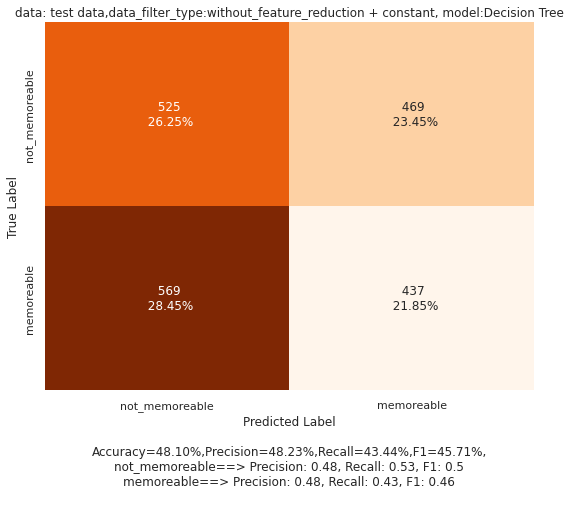

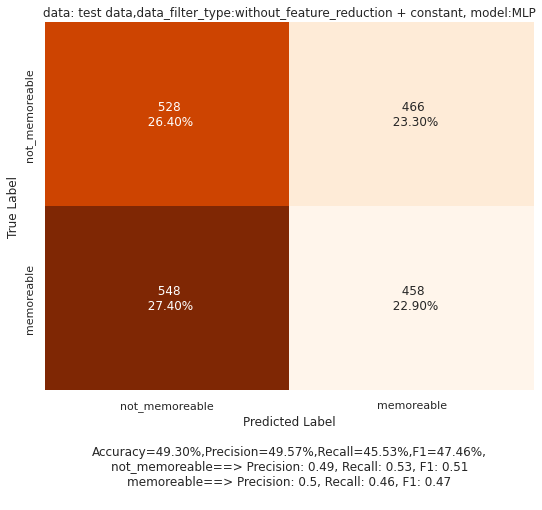

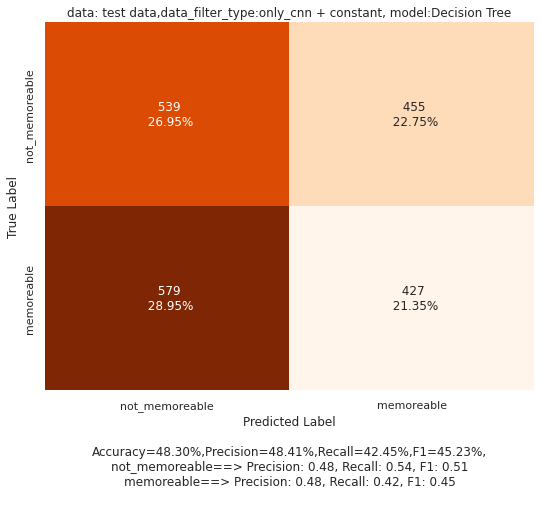

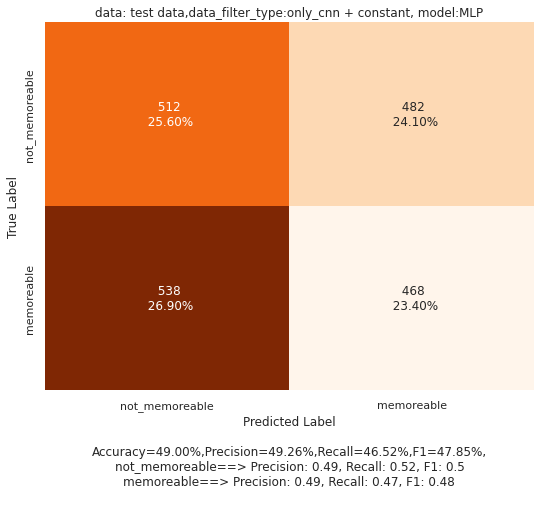

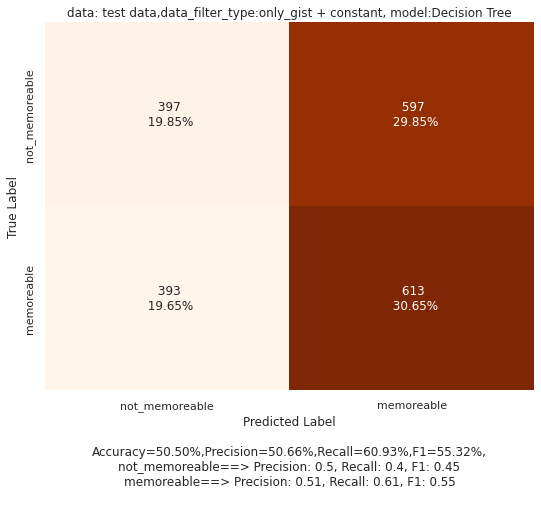

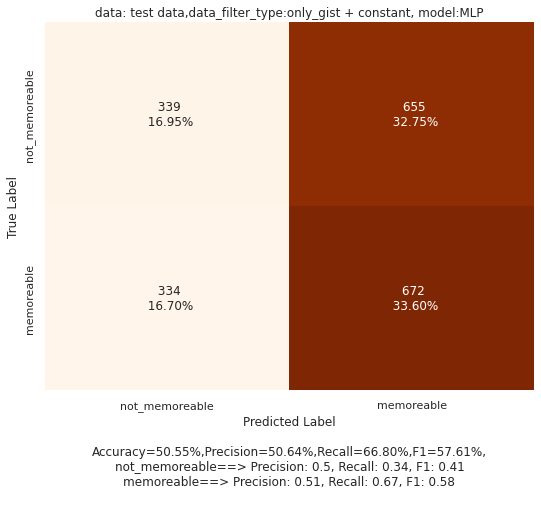

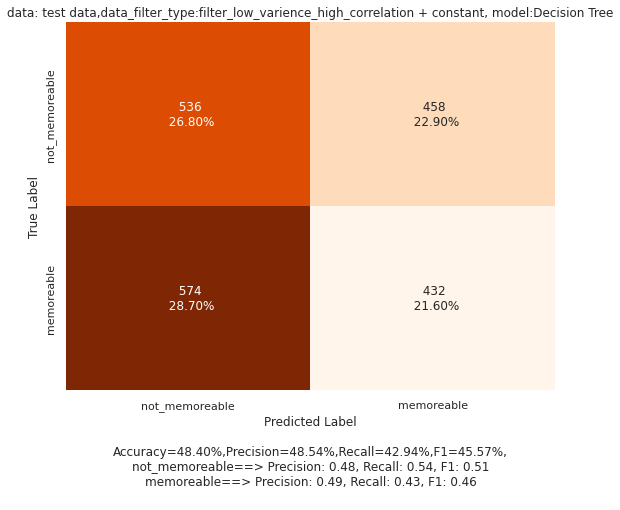

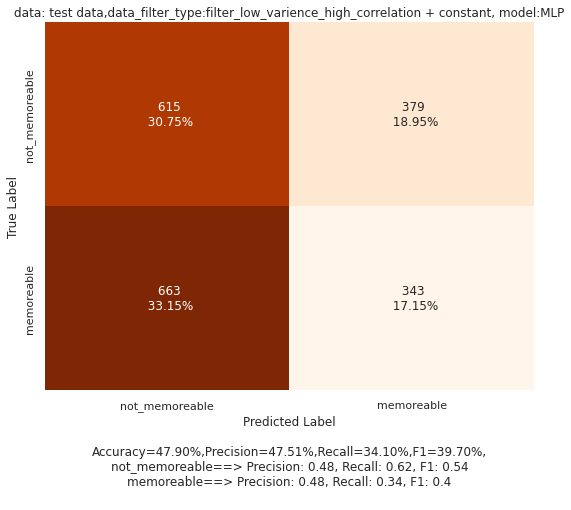

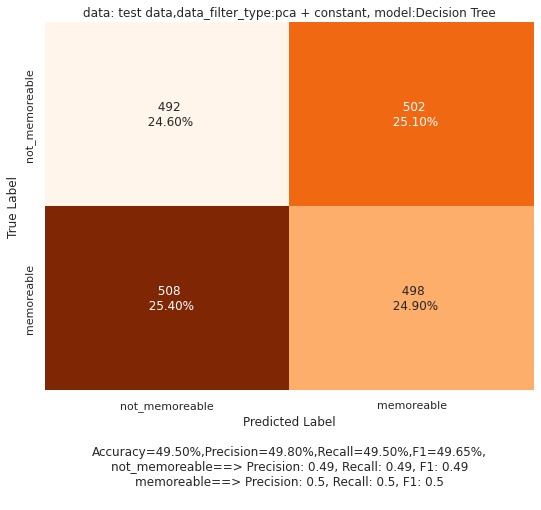

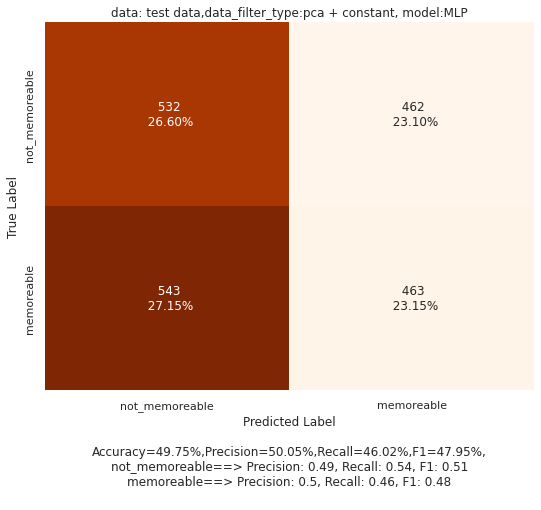

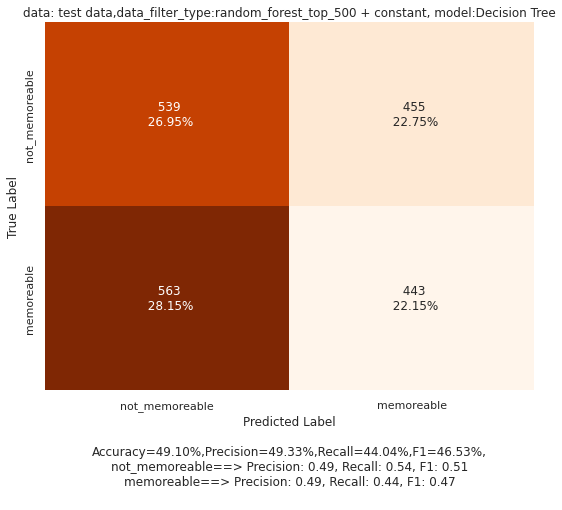

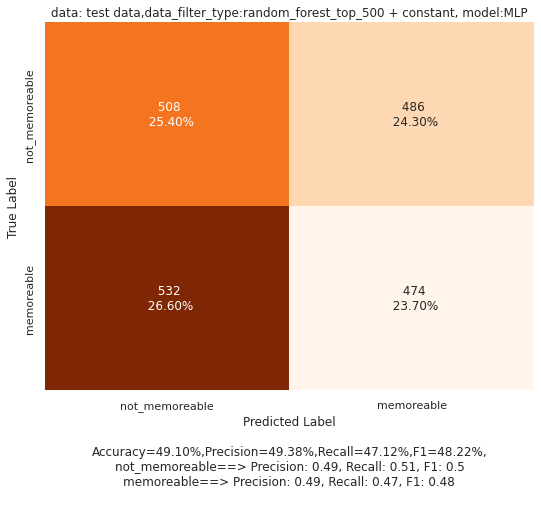

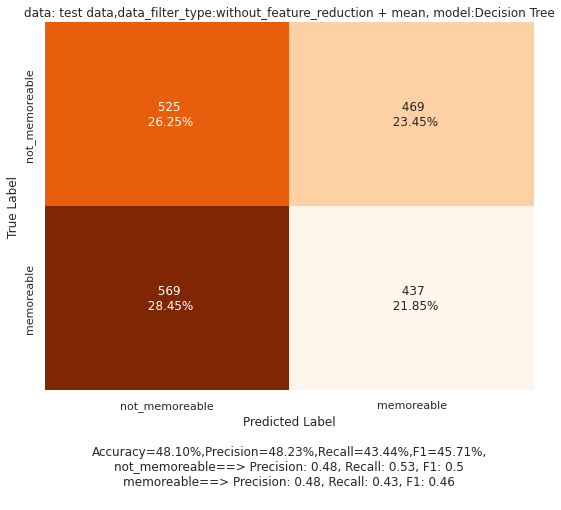

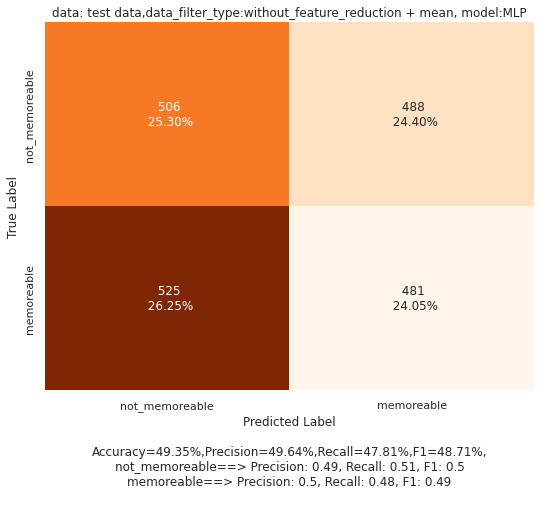

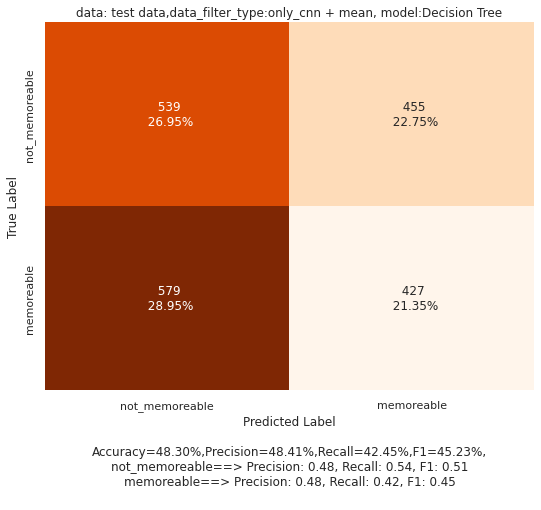

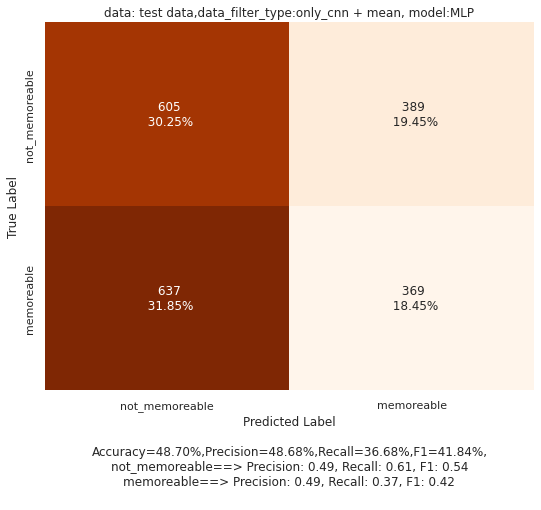

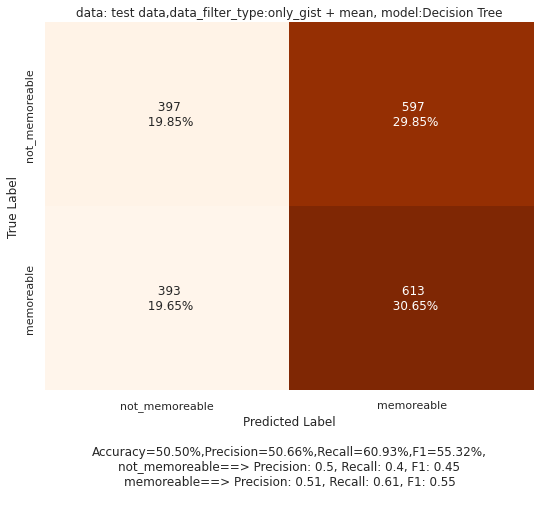

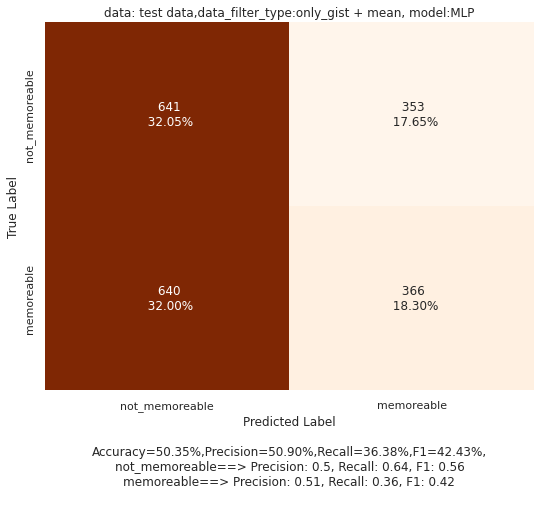

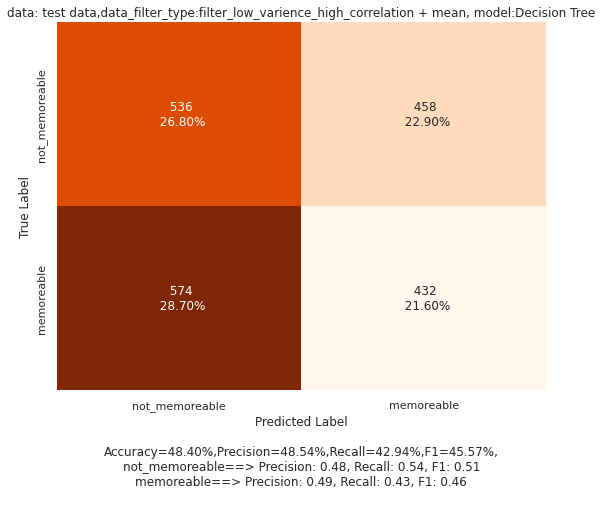

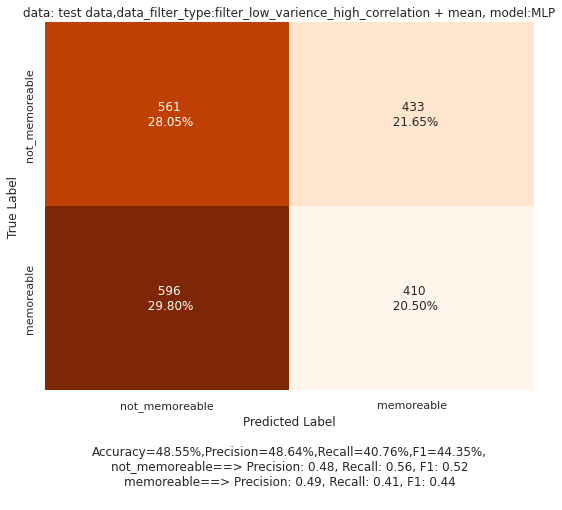

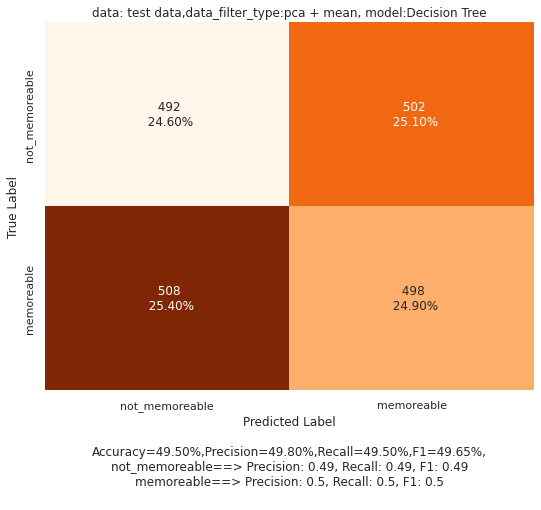

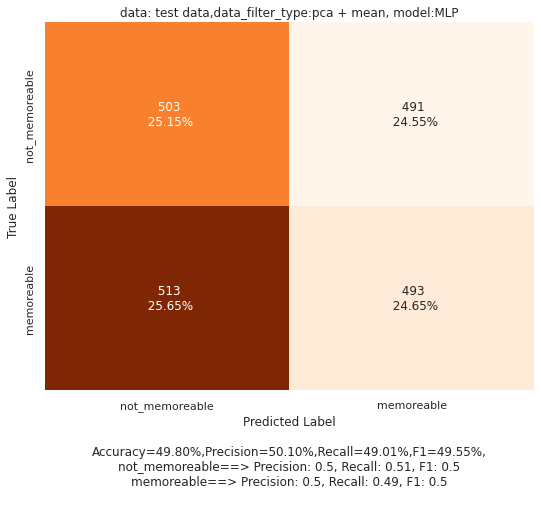

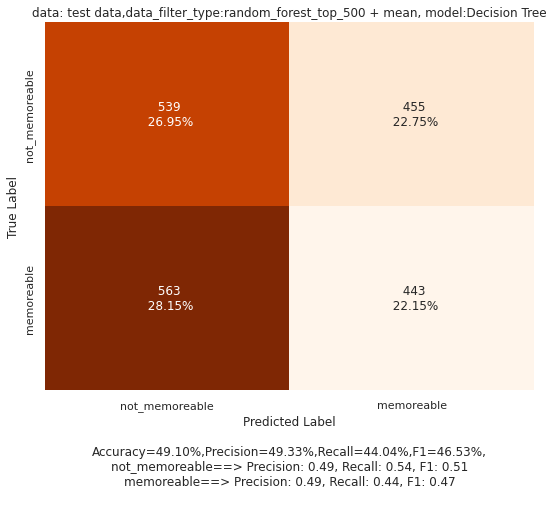

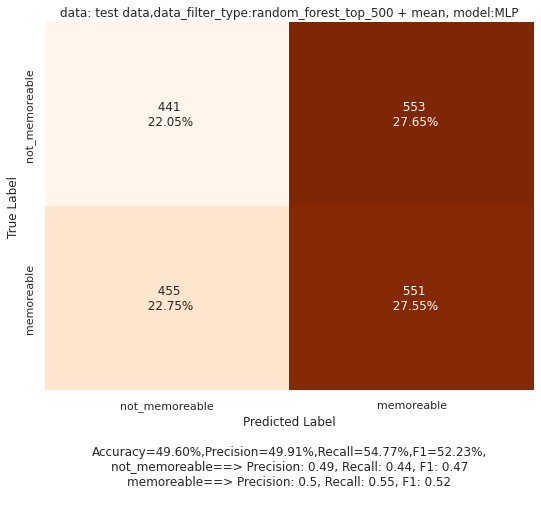

In [ ]:
# run different combination

kfold = StratifiedKFold(n_splits=5, shuffle=True)
#trying to normalize it
Gaussian_nb = GaussianNB()
#Calling one of our classifiers
Decision_tree_cls =  DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)
#Applying l1 and l2 loss
svc = SVC(gamma=0.001)

names = ["Decision Tree", "MLP"]
models = [Gaussian_nb,Decision_tree_cls,"MLP",svc]

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro',
           'f1_micro': 'f1_macro'}

run_models=[]
f1_scores =[]
for data_name, train_X, test_X in tqdm(data_combo):
  print(train_X.shape, test_X.shape)
  #scaling the features
  #scaler = preprocessing.StandardScaler().fit(train_X)
  #train_X = scaler.transform(train_X)
  #test_X = scaler.transform(test_X)
  min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
  train_X = min_max_scaler.transform(train_X)
  test_X = min_max_scaler.transform(test_X)
  for model, name in tqdm(zip(models, names), total=len(models)):
      if name =="MLP":
        model=mlp(train_X.shape[1], show_summary=False)
        model = KerasClassifier(model=model, epochs=10, batch_size=32, verbose=0)


      print(name, "  ",data_name )
      scores = cross_validate(model, train_X, train_Y, scoring=scoring, cv=kfold, return_train_score=True)
      mean_f1_train= scores['train_f1_micro'].mean()
      mean_f1_test= scores['test_f1_micro'].mean()
      print(f'Mean F1 in train: {mean_f1_train}\nMean F1 of test: {mean_f1_test}\n')

      model.fit(train_X, train_Y)
      pred = model.predict(test_X) >.5
      f1 = f1_score(test_Y, pred)
      title=f'data: test data,data_filter_type:{data_name}, model:{name}'


      run_models.append(f'{data_name} + {name}')
      f1_scores.append(f1*100)

      plot_confusion_matrix(test_Y, pred, title=title, classes=['not_memoreable','memoreable'], save_path=f"output/{title}.png")


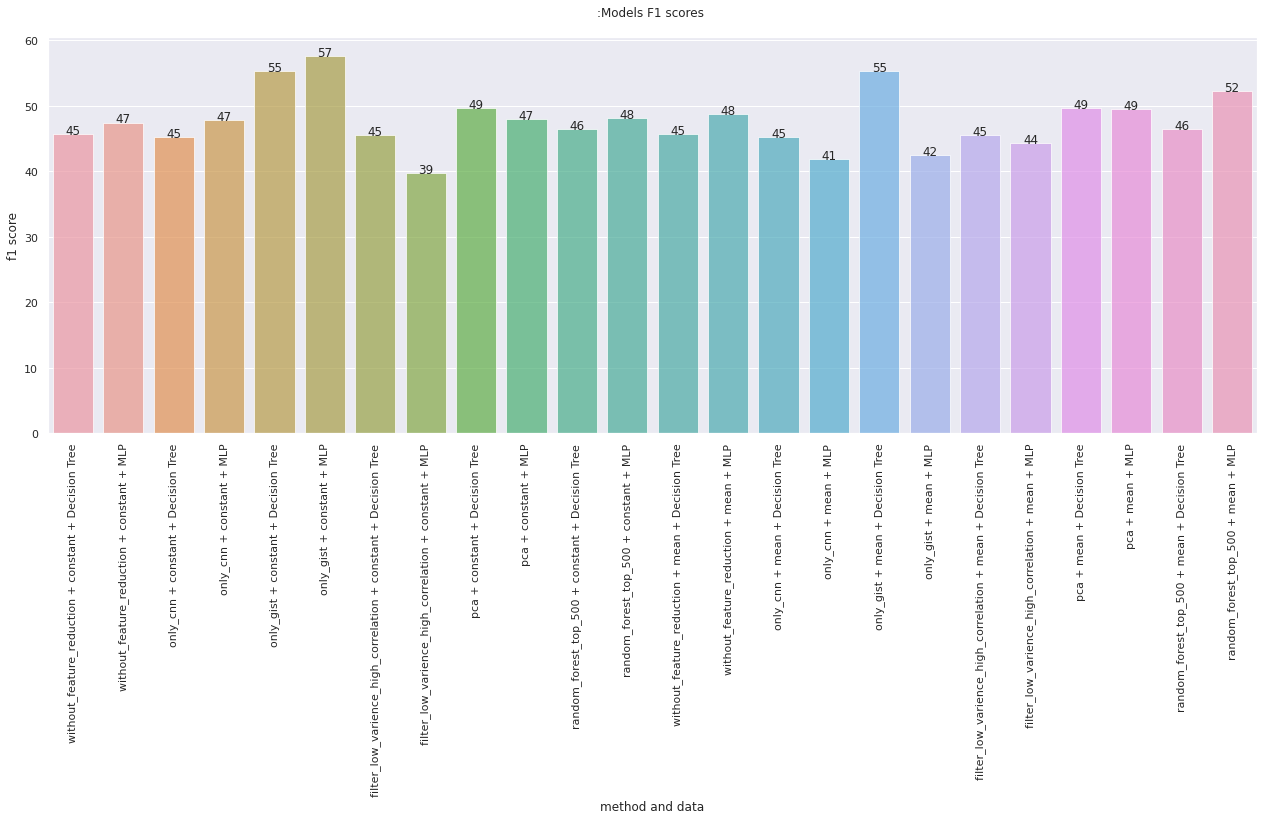

In [ ]:
_bargram(x=run_models, y=f1_scores, fig_size=[12, 5], alpha=0.7,x_label_rotation=90,h_v='v',percentige=False, text='', xlabel="method and data", ylabel="f1 score",
               title=":Models F1 scores \n", save_path='output/models_acc')

# random model check

In [ ]:
'''
Parameter
input_dim int 2998
show_summary -> boolean
returns the model after going through the layers
'''
def create_baseline(input_dim, show_summary=False):

 model = Sequential()
 #Layer one
 model.add(Dense(4096, input_dim=input_dim, activation="relu", kernel_regularizer=l2(1e-3)))
 #Ignorning half the neruons
 model.add(Dropout(0.5))
 #Layer 2
 model.add(Dense(2048, input_dim=input_dim, activation="relu", kernel_regularizer=l2(1e-2)))
 model.add(Dropout(0.5))
 model.add(Dense(1, activation='sigmoid'))


#  loss =  CategoricalCrossentropy(label_smoothing=1e-3)
  #loss function
 loss = BinaryCrossentropy(label_smoothing=1e-3)
 # Compile model
 model.compile(loss=loss, optimizer='adam', metrics=['accuracy'])
 if show_summary:
  model.summary()
 return model

In [ ]:

X_train_cnn = datasets[0][0][:,:4095]
X_train_gist = datasets[0][0][:, 4096:4608]

X_test_cnn = datasets[0][1][:,:4095]
X_test_gist = datasets[0][1][:, 4096:4608]

# # encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(y)
# y = encoder.transform(y)

In [ ]:
# fit the keras model on the dataset
X_train = datasets[0][0]
y_train = train_Y

X_test = datasets[0][1]
y_test = test_Y

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

#Different scaling made it worse
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# normalizer = preprocessing.Normalizer().fit(X_train)
# X_train = normalizer.transform(X_train)
# X_test = normalizer.transform(X_test)

In [ ]:
model1 = mlp(X_train.shape[1])
model2 = create_baseline(X_train.shape[1])

history = model1.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.3, shuffle=True)


Epoch 1/20
38/38 [==============================] - 2s 18ms/step - loss: 5.5277 - accuracy: 0.6634 - val_loss: 2.8806 - val_accuracy: 0.7275
Epoch 2/20
38/38 [==============================] - 0s 9ms/step - loss: 2.0257 - accuracy: 0.7319 - val_loss: 1.4652 - val_accuracy: 0.7373
Epoch 3/20
38/38 [==============================] - 0s 9ms/step - loss: 1.2247 - accuracy: 0.7454 - val_loss: 1.1271 - val_accuracy: 0.6696
Epoch 4/20
38/38 [==============================] - 0s 8ms/step - loss: 0.9294 - accuracy: 0.7567 - val_loss: 0.8432 - val_accuracy: 0.7618
Epoch 5/20
38/38 [==============================] - 0s 7ms/step - loss: 0.7754 - accuracy: 0.7672 - val_loss: 0.7644 - val_accuracy: 0.7500
Epoch 6/20
38/38 [==============================] - 0s 6ms/step - loss: 0.7010 - accuracy: 0.7584 - val_loss: 0.7017 - val_accuracy: 0.7529
Epoch 7/20
38/38 [==============================] - 0s 7ms/step - loss: 0.6398 - accuracy: 0.7824 - val_loss: 0.6835 - val_accuracy: 0.7608
Epoch 8/20
38/38 [=

# Evaluations

In [ ]:
# history.history.keys()
# eavaluation printing
CLASSES = ['not_memoreable','memoreable']

y_train_predicted = model1.predict(X_train) > 0.5
y_test_predicted = model1.predict(X_test) > 0.5
# y_val_proba = model.predict(X_v)

In [ ]:
print(classification_report(y_train, y_train_predicted, target_names=['not_memoreable','memoreable']))

                precision    recall  f1-score   support

not_memoreable       0.89      0.88      0.88      1827
    memoreable       0.86      0.87      0.86      1573

      accuracy                           0.87      3400
     macro avg       0.87      0.87      0.87      3400
  weighted avg       0.87      0.87      0.87      3400



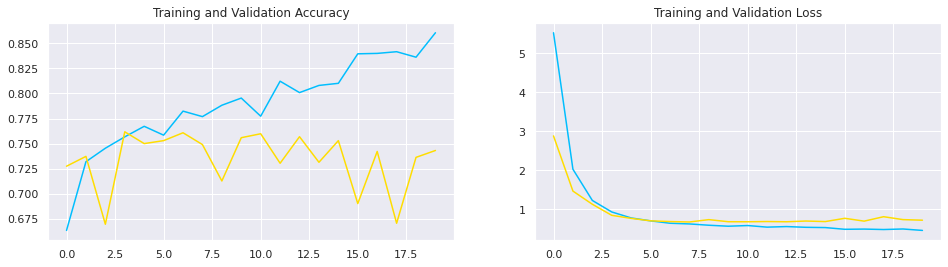

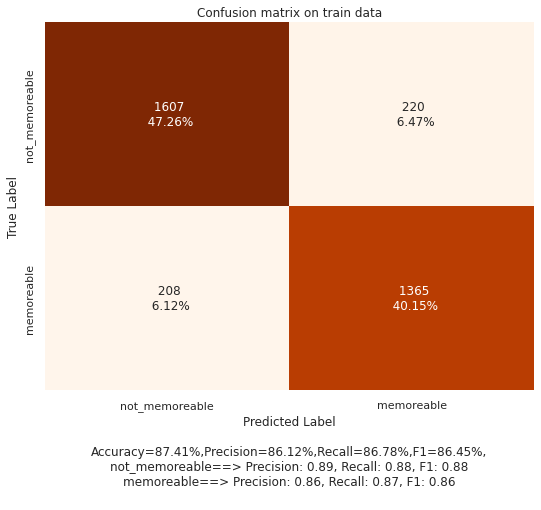

In [ ]:
plot_graph(history)
plot_confusion_matrix(y_train, y_train_predicted, title='Confusion matrix on train data', classes=CLASSES)

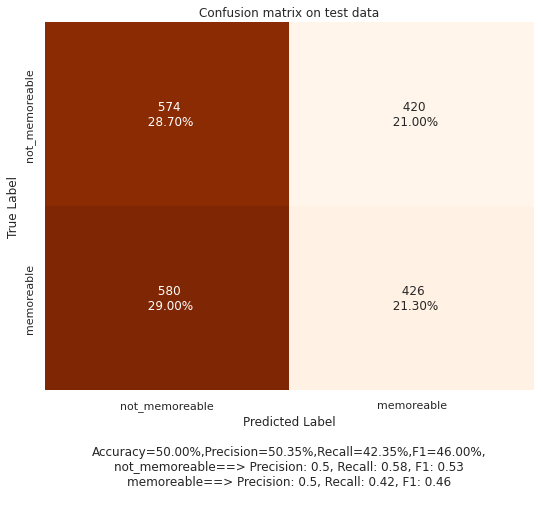

In [ ]:
plot_confusion_matrix(y_test, y_test_predicted, title='Confusion matrix on test data', classes=CLASSES)

In [ ]:
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.3, shuffle=True)

Epoch 1/20
38/38 [==============================] - 1s 20ms/step - loss: 0.5134 - accuracy: 0.8303 - val_loss: 0.7310 - val_accuracy: 0.7196
Epoch 2/20
38/38 [==============================] - 1s 16ms/step - loss: 0.4847 - accuracy: 0.8508 - val_loss: 0.7308 - val_accuracy: 0.7422
Epoch 3/20
38/38 [==============================] - 1s 16ms/step - loss: 0.4565 - accuracy: 0.8676 - val_loss: 0.7570 - val_accuracy: 0.7304
Epoch 4/20
38/38 [==============================] - 1s 16ms/step - loss: 0.4537 - accuracy: 0.8824 - val_loss: 0.7877 - val_accuracy: 0.7010
Epoch 5/20
38/38 [==============================] - 1s 16ms/step - loss: 0.4919 - accuracy: 0.8513 - val_loss: 0.7638 - val_accuracy: 0.7373
Epoch 6/20
38/38 [==============================] - 1s 16ms/step - loss: 0.4778 - accuracy: 0.8592 - val_loss: 0.7665 - val_accuracy: 0.7363
Epoch 7/20
38/38 [==============================] - 1s 16ms/step - loss: 0.4667 - accuracy: 0.8630 - val_loss: 0.8059 - val_accuracy: 0.7353
Epoch 8/20
38

In [ ]:
CLASSES = ['not_memoreable','memoreable']

y_train_predicted = model2.predict(X_train) > 0.5
y_test_predicted = model2.predict(X_test) > 0.5

In [ ]:
print(classification_report(y_train, y_train_predicted, target_names=['not_memoreable','memoreable']))

                precision    recall  f1-score   support

not_memoreable       0.69      0.96      0.80      1827
    memoreable       0.91      0.51      0.65      1573

      accuracy                           0.75      3400
     macro avg       0.80      0.73      0.73      3400
  weighted avg       0.79      0.75      0.73      3400



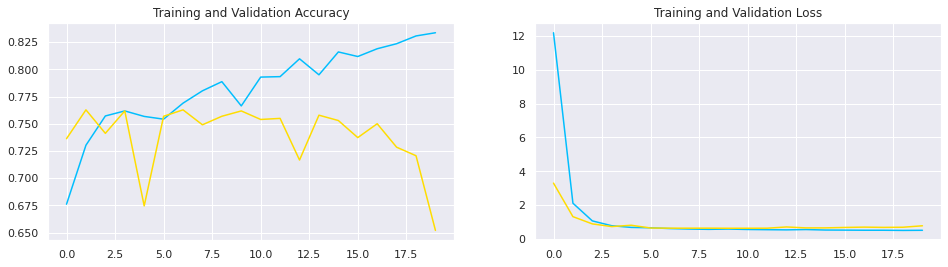

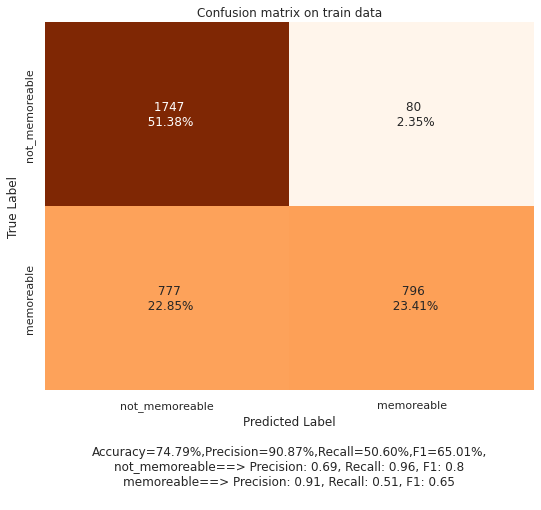

In [ ]:
plot_graph(history2)
plot_confusion_matrix(y_train, y_train_predicted, title='Confusion matrix on train data', classes=CLASSES)

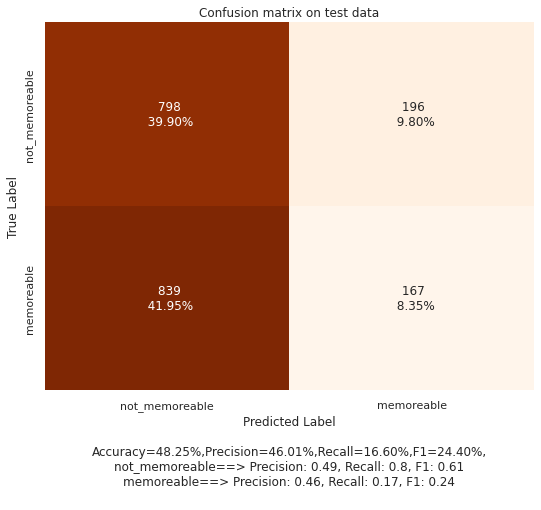

In [ ]:
plot_confusion_matrix(y_test, y_test_predicted, title='Confusion matrix on test data', classes=CLASSES)

In [ ]:
print(len(y_test_predicted))

2000


In [ ]:
print(y_test_predicted)

[[ True]
 [ True]
 [ True]
 ...
 [ True]
 [False]
 [ True]]


In [ ]:
#prediction = pd.DataFrame(y_test_predicted.astype(int), columns=['predictions']).to_csv('prediction.csv')
#from google.colab import files
#files.download("prediction.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>